In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch import nn, Tensor, TupleType
from torch.nn import Transformer

from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
class StrideDataset(Dataset):
    def __init__(self, file_path, enc_seq_len, target_seq_len, stride=5):
        df = pd.read_csv(file_path)
        self.data = df.iloc[:, 4:5].values
        self.length = len(df)

        num_samples = (self.length - enc_seq_len - target_seq_len) // stride + 1 #stride씩 움직일 때 생기는 총 sample 개수
        
        src = np.zeros([enc_seq_len, num_samples])
        trg = np.zeros([target_seq_len, num_samples])

        self.data = self.data.squeeze()

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + enc_seq_len
            src[:,i] = self.data[start_x:end_x]

            start_y = stride*i + enc_seq_len
            end_y = start_y + target_seq_len
            trg[:,i] = self.data[start_y:end_y]

        src = src.reshape(src.shape[0], src.shape[1], 1).transpose((1,0,2))
        trg = trg.reshape(trg.shape[0], trg.shape[1], 1).transpose((1,0,2))
        self.src = src
        self.trg = trg

        self.len = len(src)

    def __getitem__(self, i):
        return self.src[i], self.trg[i]
    
    def __len__(self):
        return self.len

In [3]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)

        self.x = df.iloc[:, 1:4].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
        self.y = df.iloc[:, 4:5].values
        
        self.length = len(df)

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [4]:
train_dataset = StrideDataset("180801_RFB_510cy_006_DC_20000.csv", 500, 1, stride=1)
dataset_d = CustomDataset("180801_RFB_510cy_006_DC_20000.csv")
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, drop_last=False)

In [5]:
print(train_dataset.src.shape)
print(train_dataset.trg.shape)

(19500, 500, 1)
(19500, 1, 1)


In [6]:
print(dataset_d.y.shape)
print(dataset_d.y.shape)

(20000, 1)
(20000, 1)


In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [8]:
class TFModel(nn.Module):
    def __init__(self,iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) 
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )
        
        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        ) 

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [9]:
lr = 0.001
model = TFModel(500, 1, 512, 8, 4, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
epoch = 30
model.train()
progress = tqdm(range(epoch))


for i in progress:
    batchloss = 0.0
    for (inputs, outputs) in train_dataloader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        result = model(inputs.float().to(device),  src_mask)
        loss = criterion(result, outputs[:,:,0].float().to(device))
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_dataloader)))



    # for i in progress:
    # batchloss = 0.0

    # for (inputs, tgt, tgt_y) in train_dataloader:
    #     optimizer.zero_grad()

    #     result = model(src.float().to(device), tgt.float().to(device), src_mask, tgt_mask)
    #     loss = loss_func(result, tgt_y.float().to(device))

    #     loss.backward()
    #     optimizer.step()
    #     batchloss += loss
        
    # progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_dataloader)))#??

loss: 0.024234: 100%|██████████| 30/30 [1:42:16<00:00, 204.54s/it]


In [93]:
def evaluate():
    input = torch.tensor(dataset_d.y[-500:]).reshape(1,-1,1).to(device).float().to(device)
    model.eval()
    
    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)
    return predictions.detach().cpu().numpy()

In [94]:
print(dataset_d.y.shape)

(20000, 1)


In [13]:
# def get_src_eval(seq, input_seq, output_seq, stride=1):
    
#     num_sam = (len(seq) - input_seq - output_seq) // stride + 1
    
#     src = np.zeros([input_seq, num_sam])
    
#     seq = seq.squeeze()
    
#     for i in np.arange(num_sam):
#         start_x = stride*i
#         end_x = start_x + input_seq
#         src[:,i] = seq[start_x:end_x]
        
#     src = src.reshape(src.shape[0], src.shape[1], 1).transpose((1,0,2))
    
#     src = torch.Tensor(src).to(device)
    
#     return src

In [50]:
# src = get_src_eval(dataset_d.y, 500, 1, 1)

# src.shape



eval_dataset = StrideDataset("180801_RFB_510cy_006_DC_20000.csv", 500, 1, stride=1)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False, drop_last=False)



In [23]:
ps = np.array([])

ps = np.append(ps, 1)
ps

ps = np.append(ps, 2)
ps


array([1., 2.])

In [89]:
model.eval()

predictions = np.array([])
n = 1

with torch.no_grad():
    for (inputs, outputs) in eval_dataloader:
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        print(inputs.shape)
        to_numpy = model(inputs.float().to(device), src_mask).detach().cpu().numpy()
            
        predictions = np.append(predictions, to_numpy)


print(predictions.shape)

torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 5

In [87]:
arr1 = np.zeros([1,500,1])
arr1 = torch.Tensor(arr1)

output1 = model(arr1.float().to(device), src_mask)



In [91]:
print(output1)

tensor([[1.4043]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [92]:
predictions

array([1.40427601, 1.40427601, 1.40427601, ..., 1.40427601, 1.40427601,
       1.40427601])

(19000.0, 19775.0)

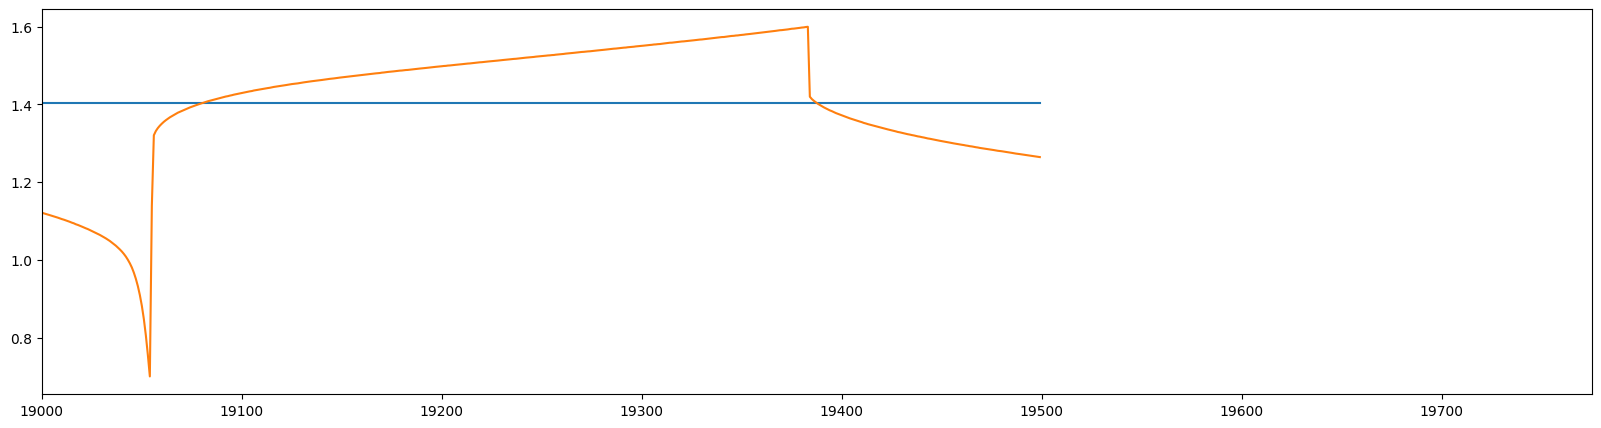

In [77]:
plt.figure(figsize=(20,5))
# plt.plot(range(20000-639,20000),dataset_d.y[20000-639:], label="real")
plt.plot(predictions, label="predict")
plt.plot(range(20000-500),dataset_d.y[500:], label="real")
plt.xlim(19000,19775)
# plt.legend()
# plt.show()

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()